# 프로젝트 02. 배경 blur 및 배경 크로마키 적용하기

## import 및 모델 준비

In [1]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
import matplotlib.pyplot as plt

# 모델 및 최신 가중치 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = deeplabv3_resnet101(weights=weights).eval().to(device)
preprocess = weights.transforms()

# 마스크 생성 함수
def get_mask(img, class_id):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_tensor = preprocess(T.ToPILImage()(img_rgb)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        preds = output.argmax(0).byte().cpu().numpy()
    mask = cv2.resize(preds, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    return (mask == class_id).astype(np.uint8) * 255

# 소프트 합성 함수 (Alpha Blending)
def soft_composite(fg, bg, mask):
    mask_soft = cv2.GaussianBlur(mask, (15, 15), 0).astype(float) / 255.0
    mask_soft = cv2.merge([mask_soft, mask_soft, mask_soft])
    result = fg.astype(float) * mask_soft + bg.astype(float) * (1.0 - mask_soft)
    return result.astype(np.uint8)

## 아기 이미지 배경 블러 처리 및 크로마키

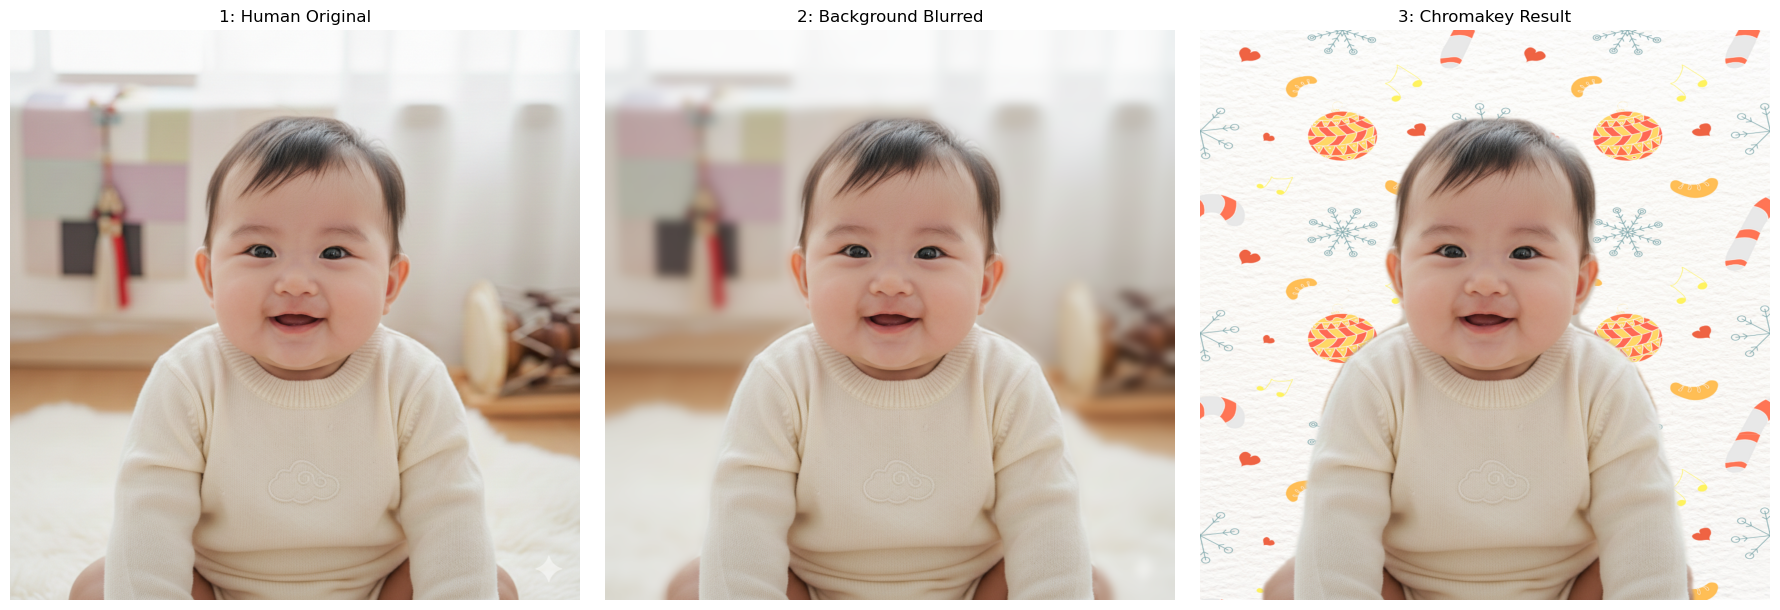

In [2]:
home_dir = os.getenv('HOME')
human_img = cv2.imread(os.path.join(home_dir, "work/human_segmentation/images/human.png"))
background_img = cv2.imread(os.path.join(home_dir, "work/human_segmentation/images/background.png"))

human_img = cv2.cvtColor(human_img, cv2.COLOR_BGR2RGB)
background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)

# 1. 아기 마스크 추출 (Person: 15)
human_mask = get_mask(human_img, class_id=15)

# 2. 배경 블러 처리 및 시각화
human_bg_blur = cv2.GaussianBlur(human_img, (51, 51), 0)
human_blurred_res = soft_composite(human_img, human_bg_blur, human_mask)

# 3. 새로운 배경으로 크로마키 및 시각화
bg_for_human = cv2.resize(background_img, (human_img.shape[1], human_img.shape[0]))
human_chroma_res = soft_composite(human_img, bg_for_human, human_mask)

# 원본, 블러 적용, 크로마키 적용 시각화
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(human_img); plt.title("1: Human Original"); plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(human_blurred_res); plt.title("2: Background Blurred"); plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(human_chroma_res); plt.title("3: Chromakey Result"); plt.axis('off')
plt.tight_layout() # 이미지 간 간격을 자동으로 조절
plt.show()

## 고양이 이미지 배경 블러 처리 및 크로마키

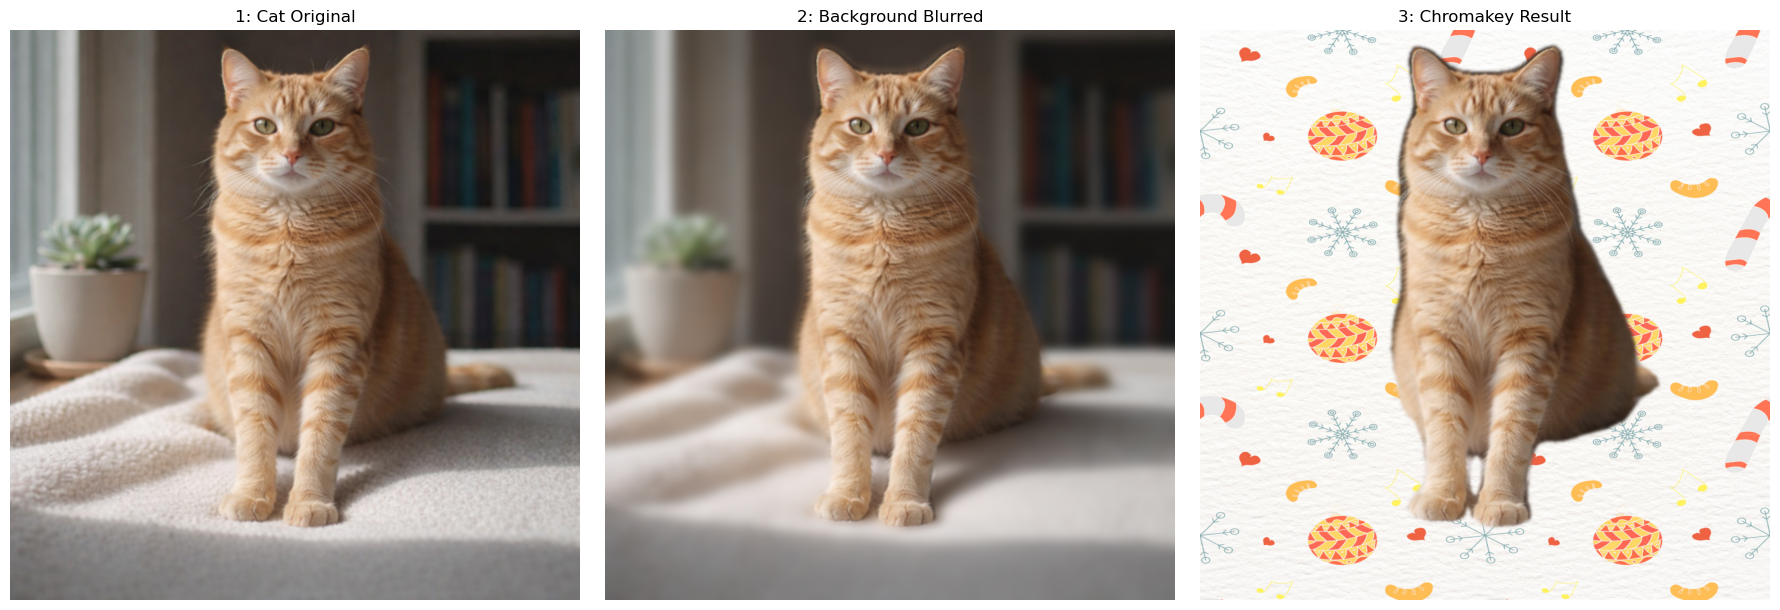

In [3]:
cat_img = cv2.imread(os.path.join(home_dir, "work/human_segmentation/images/cat.png"))
cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)

# 1. 고양이 마스크 추출 (Cat: 8)
cat_mask = get_mask(cat_img, class_id=8)

# 2. 배경 블러 처리 및 시각화
cat_bg_blur = cv2.GaussianBlur(cat_img, (51, 51), 0)
cat_blurred_res = soft_composite(cat_img, cat_bg_blur, cat_mask)

# 3. 새로운 배경으로 크로마키 및 시각화
bg_for_cat = cv2.resize(background_img, (cat_img.shape[1], cat_img.shape[0]))
cat_chroma_res = soft_composite(cat_img, bg_for_cat, cat_mask)

# 출력
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(cat_img); plt.title("1: Cat Original"); plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cat_blurred_res); plt.title("2: Background Blurred"); plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cat_chroma_res); plt.title("3: Chromakey Result"); plt.axis('off')
plt.tight_layout()
plt.show()

## 기존 실습 코드의 문제점
1. **기존 코드에서의 deeplabv3_resnet101 :**
   - 사물의 경계선을 아주 정밀하게 따내는 용도가 아니기 때문에, 결과물이 가위로 오린 것처럼 뭉툭하거나 미세한 부분을 놓치는 경우가 많다.
   - 특히 pretrained=True은 일반적인 사물 인식에 최적화되어 있어, 아주 섬세한 경계 처리는 모델 성능상 한계가 있다고 한다.
   - DeepLabV3 모델은 "이 픽셀은 사람일 확률이 90%", "저 픽셀은 고양이일 확률이 80%"라고 계산하는 역할을 한다. <br>
     최종 결과물은 각 픽셀마다 가장 확률이 높은 클래스의 번호(ID)를 매긴 데이터다.
2. **입력 크기의 강제 고정 → T.Resize((520, 520)) :**<br>
   이미지를 억지로 고정시켜버리면, 축소시켰다가 예측하고 원래 사이즈로 돌릴 때 계단 현상이 일어난다.
4. **cv2.INTER_NEAREST :**<br>
   경계선에서 부드러운 전환 없이 0 아니면 255로 딱딱하게 끊기게 만들어 "가짜 같은" 느낌을 주는 결정적인 원인
5. **seg_map = (output_predictions_resized == 15) :**<br>
   마스크를 만드는 방식 자체에 제한을 줬다.<br>
   실제 사진처럼 자연스럽게 배경과 섞이려면 경계 부분이 반투명(0.5 등)해야 하는데<br>
   픽셀이 "사람이다(1)" 아니면 "아니다(0)"라는 이진 논리로만 작동하도록 설정해서 거칠게 나오도록 원인을 제공함<br><br>

**교과서에서 제시한 솔루션에 대하여**
1. 3D/IR Camera 하드웨어 :<br>
   가장 완벽한 해결책이지만, 이 과제에서는 일반 2D 이미지를 다루고 있으므로 적용이 불가능하다.<br>
3. struct2Depth 소프트웨어 :<br>
   - 깊이(Depth)를 추정하여 거리감을 주는 훌륭한 방식이다.<br>사물이 얼마나 멀리 있나를 측정하는 기술이지, 사물의 테두리를 예쁘게 따는 기술은 아니다.
   - 주로 연속된 동영상 프레임을 분석해서 사물의 깊이(Depth)를 찾아내는데, 과제에서는 한 장의 정지 이미지를 다루고 있기 때문에<br>
   정지 화면 하나만으로는 이 기술이 사물 간의 거리감을 정확히 계산해내기 어렵다.<br><br>

## 해결책
1. **cv2.GaussianBlur(mask, (15, 15), 0)**<br>
   마스크 자체에 가우시안 블러(GaussianBlur)를 주어 경계값을 0~255 사이의 연속적인 값으로 만든다(=경계선을 반투명하게 처리). 인물과 배경의 경계가 훨씬 자연스럽게 연결된다.<br>
2. **DeepLabV3_ResNet101_Weights.DEFAULT**<br>
   현재 PyTorch에서 제공하는 가장 최신의, 가장 성능이 좋은 학습 가중치를 사용하도록 지정<br>
3. **weights.transforms()**<br>
   모델이 학습될 때와 똑같은 환경(정규화, 크기 조정 등)으로 이미지를 전처리해주는 함수.<br>
   그래서 지금 넣는 이미지도 학습 때와 똑같이 손질해서 모델에게 준다.<br>
   학습 때랑 똑같은 방식으로 전처리하면 모델 입장에서는 익숙한 포맷이기 때문에, 물체를 더 안정적으로 구분한다.